# Abstract

Every day I pursue a small **win** in one of the areas of my life that I identify as a **priority**. For example: "prog", "travel", "sport", or "social". Depending on how bit the win is, some wins are awesome.

In this study we will explore the potential impact on my life of the event of my friend J. moving out of Barcelona to his hometown, especially on my social life and number of awesome wins.

The last time I had any interaction with J. in 2023 while still in Barcelona was on August 4th. So we'll divide the Wins2023 dataset into 2 parts: days before August 5th and days starting from August 5th.

We will explore 2 hypotheses:
- H0: My life didn't really change that much, in terms of wins;
- H1: My life did change in a significant way starting from August 5th.

The main weakness of this study is that it is not a proper experiment. There might have been many confounding factors, and for sure there has been many other important events in my life that could have impacted the statistics.

Therefore, we will not be able to definitely conclude that J.'s departure had indeed caused the produced effect, should we discover any.

## Load the dependencies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy.stats as stats

%matplotlib inline

## Load the data set

In [3]:
df = pd.read_csv("../wins.csv")
df.shape

(365, 7)

## Split the data set

In [4]:
before = df.loc[df["date"] < 20230805]
before.shape

(216, 7)

In [5]:
after = df.loc[df["date"] >= 20230805]
after.shape

(149, 7)

In [6]:
days_before = before.shape[0]
days_after = after.shape[0]
(days_before, days_after)

(216, 149)

# Explore the probabilities

In [7]:
probabilities_before = before[["has_awesome_win", "social"]].sum().to_frame(name="p") / days_before
probabilities_before

,p
has_awesome_win,0.277778
social,0.453704


In [8]:
probabilities_after = after[["has_awesome_win", "social"]].sum().to_frame(name="p") / days_after
probabilities_after

,p
has_awesome_win,0.275168
social,0.436242


So it's already clear that probability of getting an awesome win didn't change at all, in both cases `P(awesome_win) = 0.28`

The only noticeable change is in the probability of getting a win related to priority "social": `0.45` vs `0.44`. But is this significant?

## Binomial test

I don't think this is appropriate test, since we don't know the `p0`, the population frequency distribution. All we have is 2, albeit large, samples.

But for the sake of this exercise, I will assume that:
- Frequency of having a win related to priority "social" in a "before" sample is a true population frequency for my life **before the event** of interest, i.e. `p0 = 0.45`.

Hypotheses:
- `H0: p = p0`
- `H1: p < P0`

Where `p` is the population frequency of having a win related to priority "social" for my life **after the event** of interest.

We will reject H0 at level `alpha = 0.05` when `p-value <= alpha`.

In [28]:
days_before

216

In [9]:
social_wins_before = before[["social"]].sum().iloc[0]
social_wins_before

98

In [10]:
p0 = probabilities_before["p"]["social"]
p0

0.4537037037037037

In [11]:
days_after

149

In [12]:
social_wins_after = after[["social"]].sum().iloc[0]
social_wins_after

65

Under `X ~ Binomial(p)`, `P(X=k) = (n choose k)*p^k*(1-p)^(n-k)`

Therefore, `P(X=65;H0)`, the probability of getting 65 wins under H0 would be:

In [13]:
def prob(p, n, k):
    return math.comb(n, k) * pow(p, k) * pow(1 - p, n - k)

p_social_under_h0 = prob(p0, days_after, social_wins_after)
p_social_under_h0

0.06001537691264045

The complete distribution of probabilities:

Text(0.5, 1.0, 'Probabilities of number of social wins in 149 days under H0')

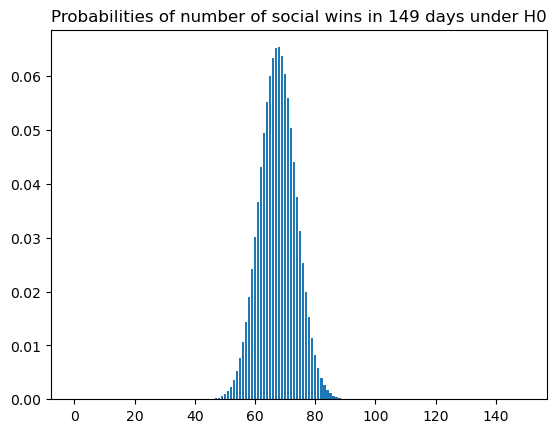

In [14]:
fig, ax = plt.subplots()
ax.bar(range(0, days_after + 1), [prob(p0, days_after, k) for k in range(0, days_after + 1)])
plt.title(f'Probabilities of number of social wins in {days_after} days under H0', fontsize=12)


The most probable number of social wins that we would expect under H0 is:

In [15]:
np.argmax([prob(p0, days_after, k) for k in range(0, days_after + 1)])

68

OK, let's finally calculate the P-value

In [16]:
sum([prob(p0, days_after, k) for k in range(0, social_wins_after + 1)])

0.36563032939637724

As p-value is much larger than 0.05, so we fail to reject H0, as based on the binomial test.

# Z-test

Now let's do the same exercise, approximating the binomial by normal.
I don't think this is an appropriate test, for the same reasons as before, but well.

The `Binomial(n, p)` can be approximated by `Normal(mu, sigma)` where `mu=n*p` and `sigma=sqrt(n*p*q)`. And we can use Standard Normal if we subtract `n*p` and divide by `sqrt(n*p*q)`.

In [29]:
# maps the value of k into the range of Standard Normal approximating the Binomial(n, p)
def standardize(p, n, k):
    return (k - n*p)/math.sqrt(n*p*(1 - p))

Text(0.5, 1.0, 'PDF of normal approximation')

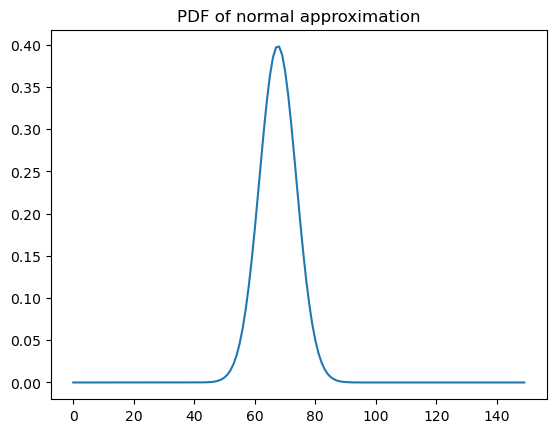

In [18]:
fig, ax = plt.subplots()
ax.plot(range(0, days_after + 1), [stats.norm.pdf(standardize(p0, days_after, k)) for k in range(0, days_after + 1)])
plt.title('PDF of normal approximation', fontsize=12)

In [32]:
z_score = standardize(p0, days_after, social_wins_after)
z_score

-0.42814328788631173

In [31]:
pvalue = stats.norm.cdf(z_score)
pvalue

0.33427340130637384

As p-value is much larger than 0.05, so we fail to reject H0, as based on the z-test.

# Chi-square test

Here again, I'm not sure this actually a good method, since our expected distribution is based on a sample, not the population. But hey, let's do it anyways

In [21]:
days_after

149

In [22]:
social_wins_after

65

In [23]:
social_non_wins_after = days_after - social_wins_after
social_non_wins_after

84

In [24]:
expected_wins_after = p0 * days_after
expected_wins_after

67.60185185185185

In [25]:
expected_non_wins_after = days_after - expected_wins_after
expected_non_wins_after

81.39814814814815

We have everything to calculate chi_square score:

In [26]:
chi_square = pow(social_wins_after - expected_wins_after, 2)/expected_wins_after + \
    pow(social_non_wins_after - expected_non_wins_after, 2)/expected_non_wins_after
chi_square

0.18330667496210118

Since we have only 2 categories, this means 1 degree of freedom. Let's calculate p-value:

In [27]:
chi_pvalue = 1 - stats.chi2.cdf(chi_square, 1)
chi_pvalue

0.6685468026127477

As p-value is much larger than 0.05, so we fail to reject H0, as based on the chi-square test.

# Conclusions

We performed 3 probably inappropriate statistical procedures, and haven't seen any statistical significance of my friend J. moving away from Barcelona, in relation to number of wins related to priority "social", or number of awesome wins.